In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Set custom styles for text color
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'  # Color of the x-axis tick values
plt.rcParams['ytick.color'] = 'white'  # Color of the y-axis tick values

# tensorflow
import tensorflow as tf
import tensorflow_decision_forests as tfdf 

# feature engineering
from sklearn.feature_selection import mutual_info_regression

import datetime

# For local run
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# For kaggle run
# train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
# test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

2023-09-05 22:23:03.053830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [3]:
# code for subplots
# data_num = data.select_dtypes(include=['int64', 'float64'])
# data_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

In [4]:
target = train.columns.to_list()[-1]
train_target = train[target]
train_target_log = np.log1p(train_target)

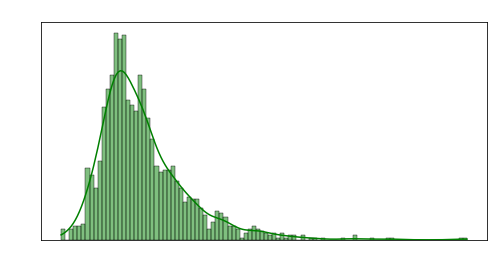

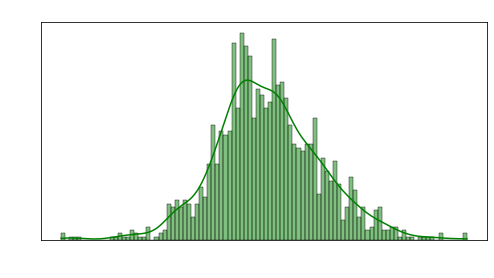

In [5]:
# normalization helps cause sale price is a bit skewed
plt.figure(figsize=(8,4))
sns.histplot(train_target, color='g', bins=100, kde=True)
plt.title('Original')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(train_target_log, color='g', bins=100, kde=True)
plt.title('Log')
plt.show()

In [6]:
train_target = train_target_log
train.drop(target, axis=1, inplace=True)
train_id = train['Id']
test_id = test['Id']
# cause Ids shouldn't go in model
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
random_seed = 1

# since feature engineering should be on both
combined = pd.concat([train, test], axis=0)

### Feature engineering

In [7]:
cat_handle = 1
num_handle = 1

if cat_handle == 1:
    cat_handle = 'FillWithMedian'
else:
    cat_handle = 'GetDummies'
    
if num_handle == 1:
    num_handle = 'log1p'
else:
    num_handle = 'BoxCox'

In [8]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

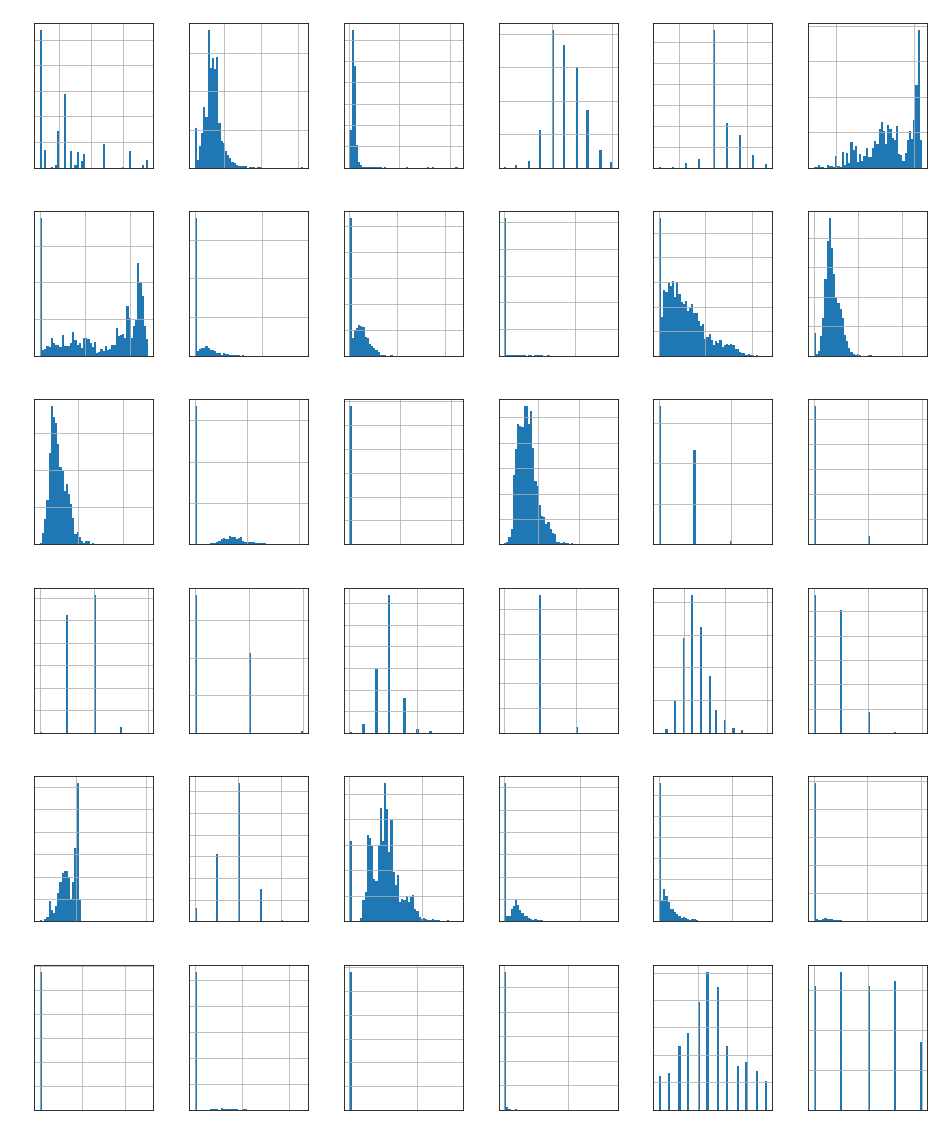

In [9]:
data_num = combined.select_dtypes(include=['int64', 'float64'])
data_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

In [10]:
# MSSubClass is cateogorical not numerical
combined['MSSubClass'] = combined['MSSubClass'].astype('object')
combined['MoSold'] = combined['MoSold'].astype('object')

In [11]:
# Ordinal features, features that have a ranking
# Convert these to numerical, cause then there is comparison rather than grouping

col_ord = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
          'GarageQual', 'GarageCond', 'PoolQC', 'FireplaceQu']
# print('Unique values', combined[col_ord].stack().unique())

for col in col_ord:
    combined[col] = combined[col].map({np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
    
# interesting point though, should mapping be based on ordinal ranking or their mean ranking
combined['BsmtFinType1'] = combined['BsmtFinType1'].map({np.nan: 0, 'Unf': 5, 'LwQ': 1, 
                                                         'BLQ': 2, 'Rec': 3, 
                                                         'ALQ': 4, 'GLQ': 6})
combined['BsmtFinType2'] = combined['BsmtFinType2'].map({np.nan: 0, 'Unf': 5, 'LwQ': 1, 
                                                         'BLQ': 2, 'Rec': 3, 
                                                         'ALQ': 4, 'GLQ': 6})
combined['Functional'] = combined['Functional'].map({np.nan: 0, 'Sev': 1, 'Maj2': 2, 
                                                     'Maj1': 3, 'Mod': 4, 
                                                     'Min2': 5, 'Min1': 6, 'Typ': 7})
combined['Fence'] = combined['Fence'].map({np.nan: 0, 'MnWw': 1, 'MnPrv': 2, 
                                           'GdWo': 3, 'GdPrv': 4})
combined['BsmtExposure'] = combined['BsmtExposure'].map({np.nan:0, 'No': 1, 
                                                         'Mn': 2, 'Av': 3, 'Gd': 4})
combined['GarageFinish'] = combined['GarageFinish'].map({np.nan: 0, 'Unf': 1, 
                                                         'RFn': 2, 'Fin': 3})

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice'>

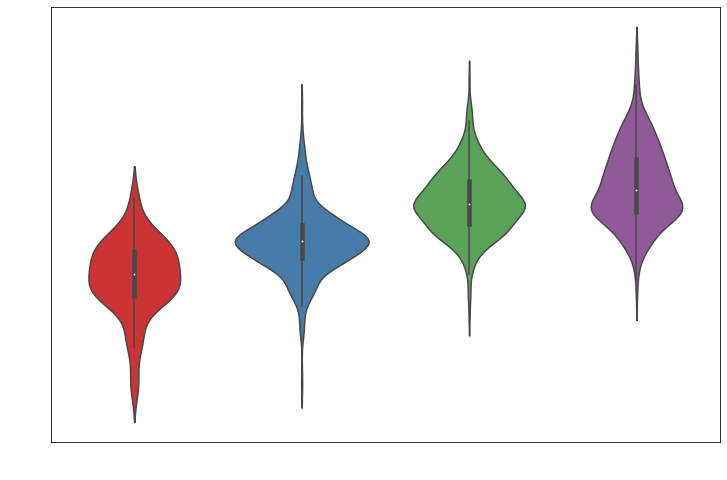

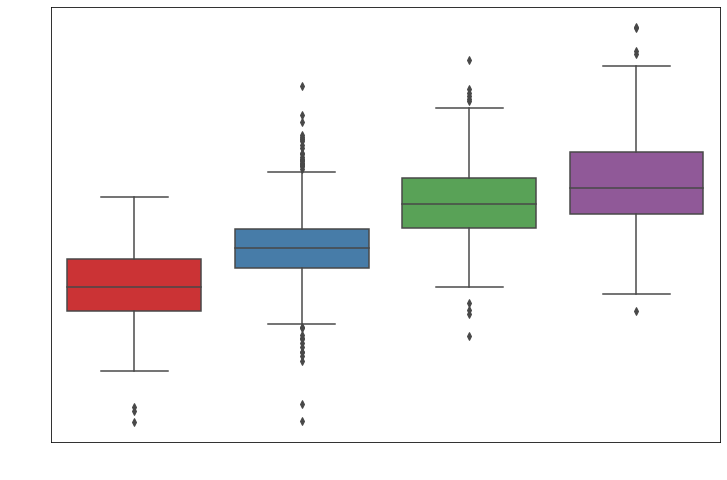

In [12]:
# visualize to help understand the distribution rnaking
col = 'GarageFinish'
X = combined[:train_id.shape[0]][[col]]
X['SalePrice'] = train_target

plt.figure(figsize=(12,8))
sns.violinplot(x=col, y="SalePrice", palette="Set1", data=X)

plt.figure(figsize=(12,8))
sns.boxplot(x=col, y="SalePrice", palette="Set1", data=X)

In [13]:
# fill with None/0
col_cat_NA = ['Alley', 'GarageType', 'GarageFinish', 'MiscFeature']
for col in col_cat_NA:
    combined[col].fillna('None', inplace=True)
    
col_num_NA = ['BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']
for col in col_num_NA:
    combined[col].fillna(0, inplace=True)
    
# based on neighborhood
col_nul_nbr = ['LotFrontage', 'GarageCars', 'GarageArea']
for col in col_nul_nbr:
    combined[col] = combined.groupby(
        'Neighborhood')[col].transform(lambda x: x.fillna(x.median()))
    
# based on neighborhood and overall quality
col_cat_nbr_ovrlqual = ['Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                       'Electrical', 'SaleType']
for col in col_cat_nbr_ovrlqual:
    combined[col] = combined.groupby(
        ['Neighborhood', 'OverallQual'])[col].transform(
        lambda x: x.fillna(x.mode()[0]))
    
col_num_nbr_ovrlqual = ['MasVnrArea']
for col in col_num_nbr_ovrlqual:
    combined[col] = combined.groupby(
        ['Neighborhood', 'OverallQual'])[col].transform(lambda x: x.fillna(x.mean()))
    
# based on MSSubClass
combined['MSZoning'] = combined.groupby(
    'MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# basement surface area from other features
combined['TotalBsmtSF'].fillna(combined['BsmtFinSF1'] + 
                               combined['BsmtFinSF2'] + 
                               combined['BsmtUnfSF'], inplace=True)

# come back to this later!!!!!!!!!!!!!!!!!!!!!
combined['GarageYrBlt'].fillna(combined['YearBuilt'], inplace=True)

In [14]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [15]:
# support functions
# check remaning nulls
combined.isnull().sum()[combined.isnull().sum()>0].sort_values(ascending=False)
# np.unique(combined['Fence'], return_counts=True)
# for col in col_year:
#     display(combined[col].sort_values())

Series([], dtype: int64)

In [16]:
# add some features, some of these features have very high frequency of one value
combined['TotalSF'] = combined['TotalBsmtSF'] + combined['1stFlrSF'] + combined['2ndFlrSF']
combined['HasWoodDeck'] = (combined['WoodDeckSF']==0)*1
combined['HasOpenPorch'] = (combined['OpenPorchSF']==0)*1
combined['HasEnclosedPorch'] = (combined['EnclosedPorch']==0)*1
combined['HasPool'] = (combined['PoolArea']==0)*1
# like 2882 counts of 0
combined['Has3SsnPorch'] = (combined['3SsnPorch']==0)*1
combined['TotalBath'] = (combined['BsmtFullBath'] + combined['BsmtHalfBath']*0.5 + 
                         combined['FullBath'] + combined['HalfBath']*0.5)
combined['TotalProch'] = (combined['WoodDeckSF'] + combined['OpenPorchSF'] + 
                          combined['EnclosedPorch'] + combined['3SsnPorch'] + 
                          combined['ScreenPorch'])

In [17]:
# correct outliers/inaccuracy
combined.loc[combined['GarageYrBlt']==2207, 'GarageYrBlt'] = 2007

In [18]:
col_year = ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'YrSold']
current_year = datetime.datetime.now().year
for col in col_year:
    combined[col] = current_year - combined[col]

### Model design

In [19]:
train = combined.iloc[:train_id.shape[0]]
test = combined.iloc[-test_id.shape[0]:]
train[target] = train_target

/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_90037/1354609982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[target] = train_target


In [20]:
def train_test_split(data, test_ratio = 0.3):
    test_indices = np.random.rand(data.shape[0]) < test_ratio
    return data[~test_indices], data[test_indices]

train_data, test_data = train_test_split(train)
print('{} samples in training data, {} in testing'.format(
    train_data.shape[0],test_data.shape[0]))

1016 samples in training data, 444 in testing


In [21]:
# convert to tensorflow datasets
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=target,
                                                  task=tfdf.keras.Task.REGRESSION)
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=target,
                                                 task=tfdf.keras.Task.REGRESSION)

Model: TFDF

In [22]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics='mse')

Use /var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/tmp2vce4lff as temporary training directory


In [23]:
rf.fit(x=train_data)

Reading training dataset...
Training dataset read in 0:00:04.080912. Found 1016 examples.
Training model...


[INFO 23-09-05 22:23:17.7815 MDT kernel.cc:1243] Loading model from path /var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/tmp2vce4lff/model/ with prefix df2fedba7d79483f
[INFO 23-09-05 22:23:17.9640 MDT decision_forest.cc:660] Model loaded with 300 root(s), 96876 node(s), and 84 input feature(s).
[INFO 23-09-05 22:23:17.9640 MDT abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-09-05 22:23:17.9640 MDT kernel.cc:1075] Use fast generic engine


Model trained in 0:00:00.676677
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [24]:
# tfdf.model_plotter.plot_model_in_colab(rf, max_depth=5, tree_idx=0)

In [25]:
inspector = rf.make_inspector()
logs = inspector.training_logs()
display(logs)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=382, accuracy=None, loss=None, rmse=0.21705845902914814, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=1015, accuracy=None, loss=None, rmse=0.16318005565835694, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=1016, accuracy=None, loss=None, rmse=0.14889319167265339, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=1016, accuracy=None, loss=None, rmse=0.14559548033775158, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=1016, accuracy=None, loss=None, rmse=0.1442908209967888, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=1016, accuracy=None, loss=None, rmse=0.1423301754307025, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=61, ev

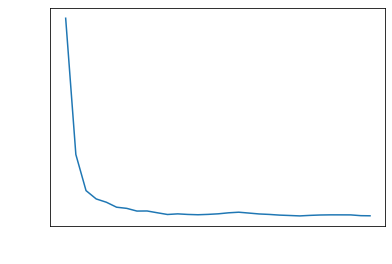

In [26]:
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel('# of trees')
plt.ylabel('rmse')
plt.show()

In [27]:
inspector.evaluation()

Evaluation(num_examples=1016, accuracy=None, loss=None, rmse=0.1389325080267308, ndcg=None, aucs=None, auuc=None, qini=None)

In [28]:
# let's evaluate using our testing set
evaluation = rf.evaluate(x=test_data, return_dict=True)
display(evaluation)

1/1 [==============================] - 0s 409ms/step - loss: 0.0000e+00 - mse: 0.0179


{'loss': 0.0, 'mse': 0.01793237030506134}

Random Forest Variable Importance

In [29]:
inspector.variable_importances().keys()

dict_keys(['INV_MEAN_MIN_DEPTH', 'NUM_AS_ROOT', 'SUM_SCORE', 'NUM_NODES'])

In [30]:
inspector.variable_importances()['SUM_SCORE'][0:5]

[("TotalSF" (1; #81), 12711.308625637761),
 ("OverallQual" (1; #67), 10361.516059808906),
 ("Neighborhood" (4; #64), 5765.412584800243),
 ("GrLivArea" (1; #38), 2374.7311308094704),
 ("ExterQual" (1; #22), 1998.8781205057712)]

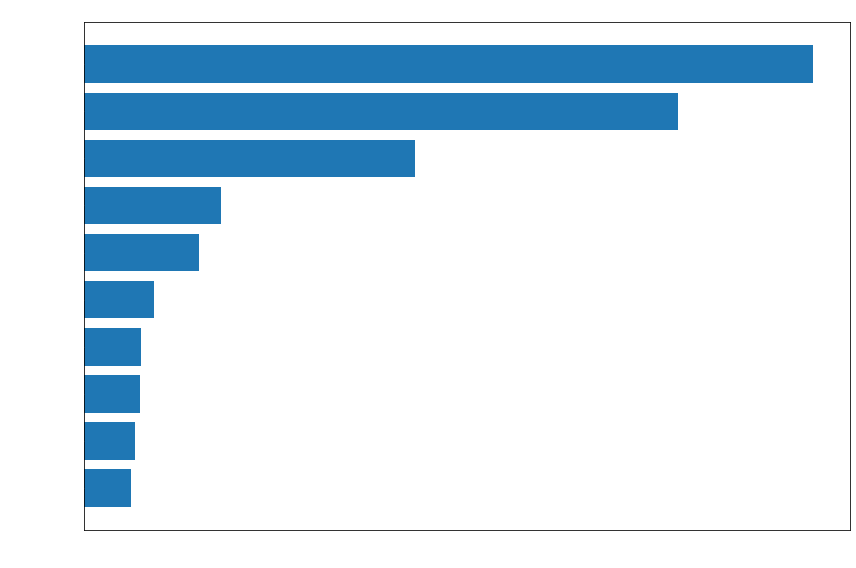

In [31]:
plt.figure(figsize=(12,8))

var_importance_metric = 'SUM_SCORE'
var_importances = inspector.variable_importances()[var_importance_metric]

feature_names = [v[0].name for v in var_importances][0:10]
feature_importance = [v[1] for v in var_importances][0:10]

# since they are in descending importance already
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_names, feature_importance, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis() # inverses order of bars appearing

for importance, patch in zip(feature_importance, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance/1e12:.0f}T", va="top")

plt.xlabel('Importance')
plt.title(var_importance_metric + ' feature importance')
plt.tight_layout()
plt.show()

Predictions

In [32]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,TotalSF,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,HasPool,Has3SsnPorch,TotalBath,TotalProch
0,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,...,WD,Normal,1778.0,0,1,1,1,1,1.0,260
1,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,...,WD,Normal,2658.0,0,0,1,1,1,1.5,429
2,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,...,WD,Normal,2557.0,0,0,1,1,1,2.5,246
3,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,...,WD,Normal,2530.0,0,0,1,1,1,2.5,396
4,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,...,WD,Normal,2560.0,1,0,1,1,1,2.0,226


In [33]:
test.shape

(1459, 87)

In [34]:
test = tfdf.keras.pd_dataframe_to_tf_dataset(test, task=tfdf.keras.Task.REGRESSION)
predictions = rf.predict(test)
output = pd.DataFrame({'Id':test_id, 'SalePrice': predictions.squeeze()})

# undo the log, essentially do expo
output['SalePrice'] = np.expm1(output['SalePrice'])
output

2/2 [==============================] - 0s 14ms/step


,Id,SalePrice
0,1461,122527.718750
1,1462,156929.187500
2,1463,182376.390625
3,1464,184288.968750
4,1465,194565.031250
...,...,...
1454,2915,90034.812500
1455,2916,91887.609375
1456,2917,156429.062500
1457,2918,113748.632812


In [35]:
submission.loc[submission['Id'].isin(output['Id']), 'SalePrice'] = output['SalePrice']
submission

,Id,SalePrice
0,1461,122527.718750
1,1462,156929.187500
2,1463,182376.390625
3,1464,184288.968750
4,1465,194565.031250
...,...,...
1454,2915,90034.812500
1455,2916,91887.609375
1456,2917,156429.062500
1457,2918,113748.632812


In [36]:
submission.to_csv('data/submission.csv', index=False)